# Will Couples Stay Together?

Because I love asking the important questions. Also explain your predictions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown

from DataScienceUtils import GetSubsetTransform
from DataScienceUtils.models import PreTrainedVoteEnsemble
from DataScienceUtils.graphing import plot_roc_curve
from lime.lime_tabular import LimeTabularExplainer

from sklearn.base import ClassifierMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

graph.style.use('fivethirtyeight')

Using TensorFlow backend.
/home/stephen/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# EDA

In [2]:
# Load data (Came from Stanford https://data.stanford.edu/hcmst)
df = pd.read_csv('data/couples.csv')

print(df.shape)
display(df.head(3))
display(df.info())

(1473, 22)


,caseid_new,marital_status,age,partner_age,education,partner_education,ethnicity,children,visits_relatives,gender,...,msa,rent,political,religion,work,lgbtq,success,age_diff_abs,gender_older,education_difference
0,22526,living with partner,52,48,bachelor's degree or higher,some college,hispanic,0.0,0,female,...,metro,rented for cash,democrat,catholic,working - as a paid employee,0,1.0,4,1,1
1,23286,living with partner,28,30,bachelor's degree or higher,bachelor's degree or higher,"white, non-hispanic",0.0,0,female,...,metro,rented for cash,democrat,jewish,working - as a paid employee,0,1.0,2,0,0
2,26315,never married,31,40,some college,high school,"white, non-hispanic",0.0,1,male,...,metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,0,0.0,9,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 22 columns):
caseid_new              1473 non-null int64
marital_status          1473 non-null object
age                     1473 non-null int64
partner_age             1473 non-null int64
education               1473 non-null object
partner_education       1473 non-null object
ethnicity               1473 non-null object
children                1473 non-null float64
visits_relatives        1473 non-null int64
gender                  1473 non-null object
house                   1473 non-null object
income                  1473 non-null object
msa                     1473 non-null object
rent                    1473 non-null object
political               1473 non-null object
religion                1473 non-null object
work                    1473 non-null object
lgbtq                   1473 non-null int64
success                 1473 non-null float64
age_diff_abs            1473 non-null int

None

## String Features

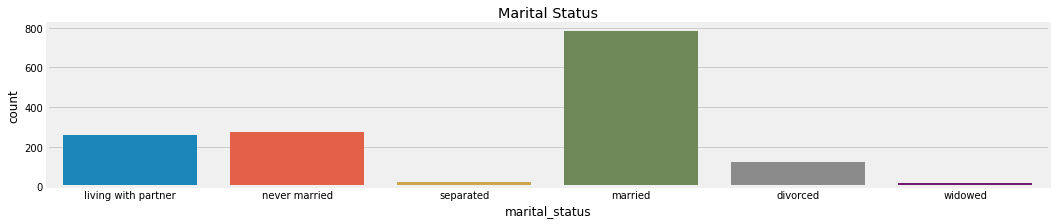

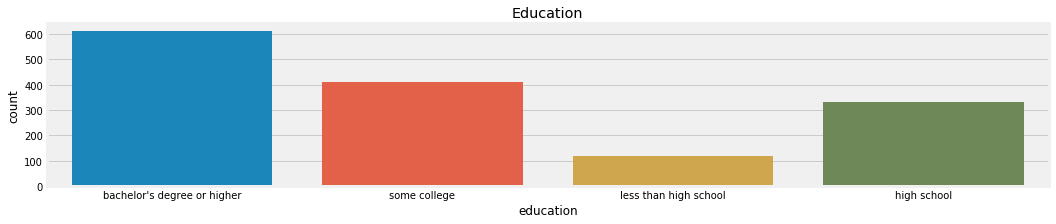

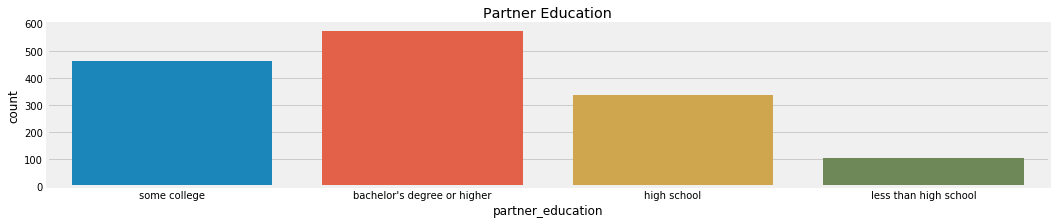

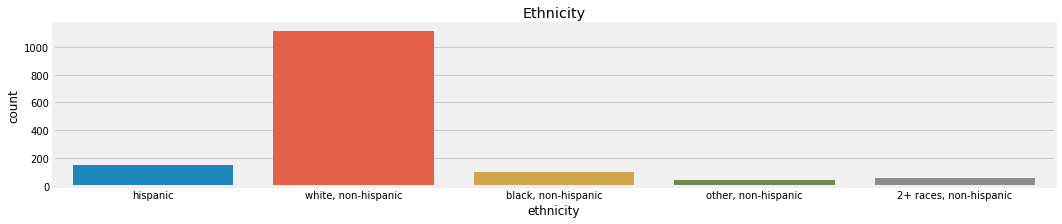

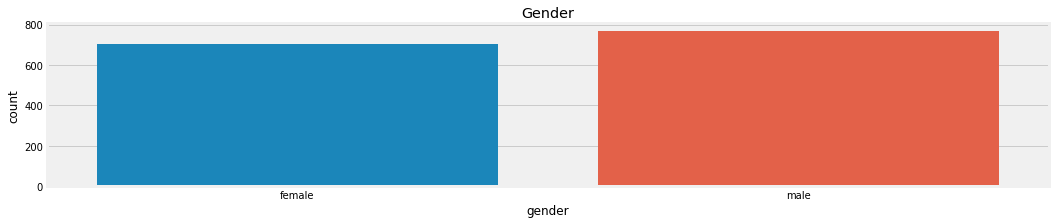

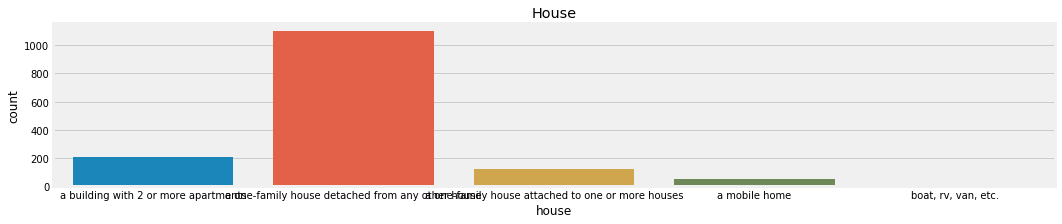

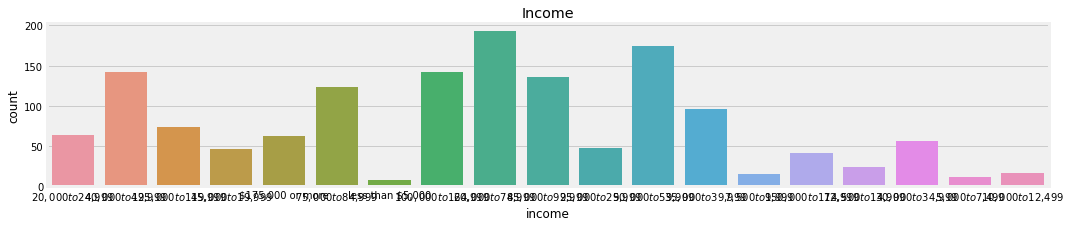

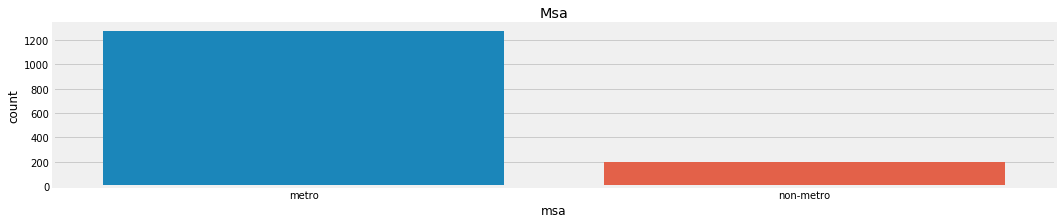

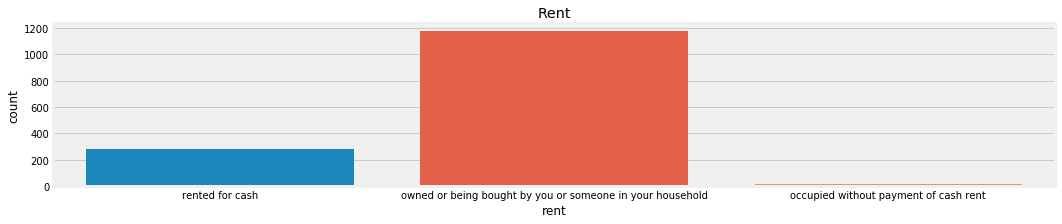

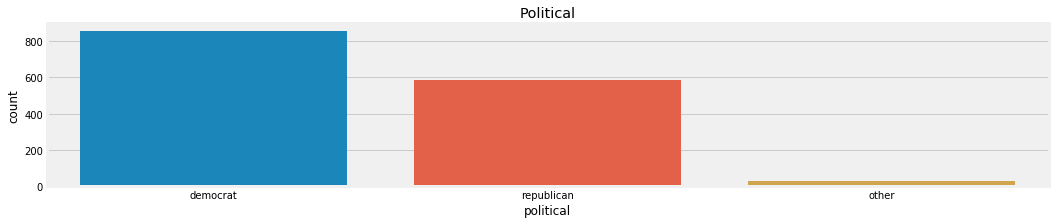

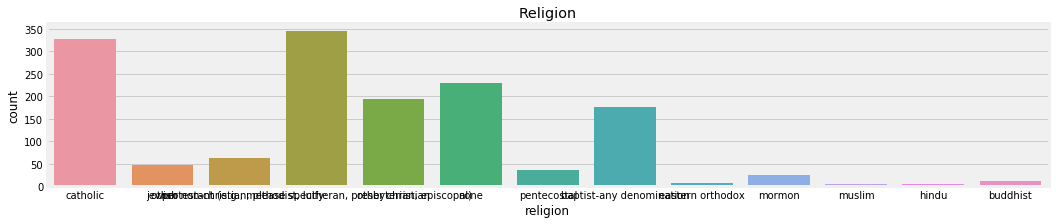

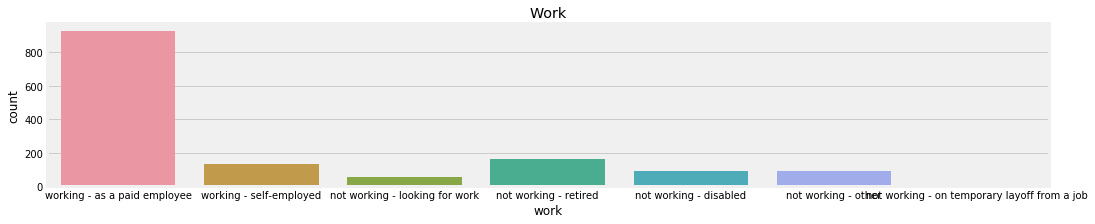

## Numeric Features

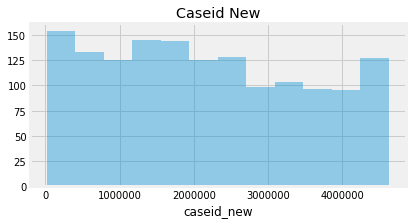

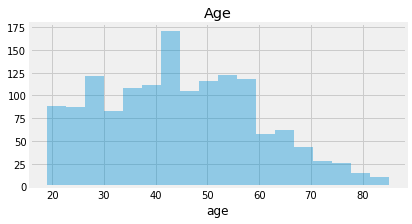

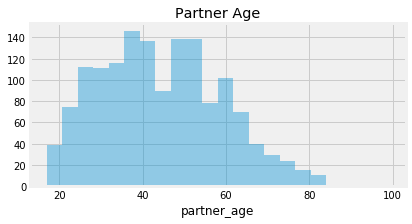

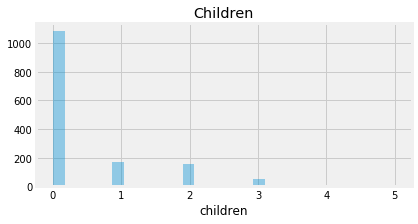

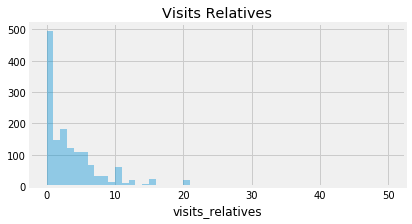

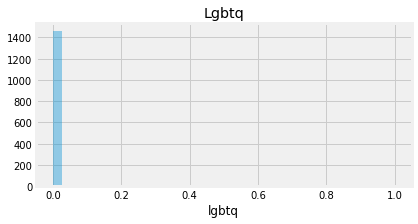

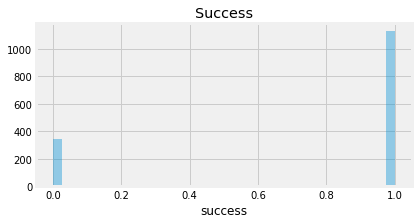

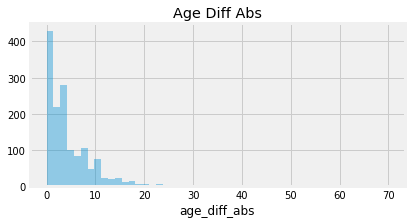

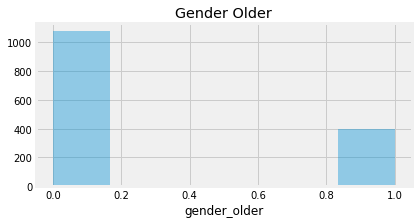

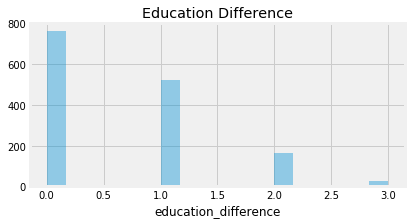

In [3]:
# Feature Exploration

display(Markdown('## String Features'))
for col in df.select_dtypes(include=['object']):
    graph.figure(figsize=(16, 3))
    graph.title(col.replace('_', ' ').title())
    sns.countplot(df[col])
    graph.show()
    
display(Markdown('## Numeric Features'))
for col in df.select_dtypes(include=['int64', 'float64']):
    graph.figure(figsize=(6, 3))
    graph.title(col.replace('_', ' ').title())
    sns.distplot(df[col], kde=False)
    graph.show()

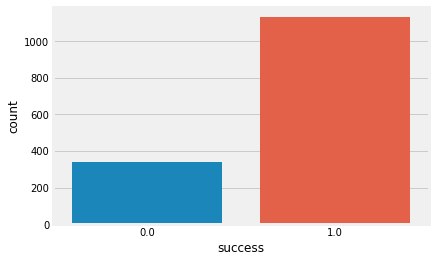

In [4]:
# Target Variable
sns.countplot(df['success'])
graph.show()

This dataset has very interesting biases. I'm going to need a score that deals with this well. Something between AUC, F1 Score, Matthews Correlation Coeffiecent.

I'm currently leaning on the Matthew and F1 score.

Also looks like Stanford did an absolutely amazing job cleaning this data! So it will be dope!

# Preping Data

In [5]:
# This feature order allows for easier slicing so don't fuck with it.
features = [
    'success',
    'age',
    'partner_age',
    'age_diff_abs',
    'children',
    'visits_relatives',
    'education',
    'marital_status',
    'partner_education',
    'gender',
    'house',
    'income',
    'msa',
    'rent',
    'political',
    'religion',
    'work',
    'gender_older',
    'education_difference'
]

df = df[features]
df = df[df['house'] != 'boat, rv, van, etc.']  # perfect information

print(df.shape)

(1472, 19)


In [6]:
# Splitting and preping data for Machine Learning
feature_names = df.columns[1:].tolist()
feature_indices = np.arange(len(feature_names))
print(feature_names, feature_indices)

def split_for(obj, continuous=True):
    return obj[:5] if continuous else obj[5:]

y, x = df['success'].values, df[df.columns[1:]].values

# Encode Labels
label_encoders = {}
for col_index, feature_name in zip(split_for(feature_indices, False), split_for(feature_names, False)):
    le = LabelEncoder()
    x[:, col_index] = le.fit_transform(x[:, col_index])
    label_encoders[feature_name] = le
    
# Unify datatypes for models like Neural Networks
x = x.astype(float)

# How does it look?
print(y.shape, x.shape)
display(x)

# Train test stratified split (This should get us pretty good resolution)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=200, stratify=y, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

['age', 'partner_age', 'age_diff_abs', 'children', 'visits_relatives', 'education', 'marital_status', 'partner_education', 'gender', 'house', 'income', 'msa', 'rent', 'political', 'religion', 'work', 'gender_older', 'education_difference'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
(1472,) (1472, 18)


array([[ 52.,  48.,   4., ...,   5.,   1.,   1.],
       [ 28.,  30.,   2., ...,   5.,   0.,   0.],
       [ 31.,  40.,   9., ...,   5.,   1.,   1.],
       ..., 
       [ 33.,  33.,   0., ...,   5.,   0.,   1.],
       [ 29.,  29.,   0., ...,   5.,   0.,   0.],
       [ 37.,  38.,   1., ...,   5.,   1.,   0.]])

(1272, 18) (200, 18) (1272,) (200,)


# Modeling

In [7]:
# Create a feature preprocessing pipeline since you cannot* standardise One Hot Features
numeric_branch = Pipeline([
    ('get-numeric', GetSubsetTransform(split_for(feature_indices, continuous=True))),
    ('standardise', StandardScaler())
])
categorical_branch = Pipeline([
    ('get-categorical', GetSubsetTransform(split_for(feature_indices, continuous=False))),
    ('one-hot', OneHotEncoder(sparse=False))
])
preprocessor = FeatureUnion(transformer_list=[
    ('numeric-branch', numeric_branch),
    ('categorical-branch', categorical_branch)
])

In [8]:
def evaluate(model, xs, ys):
    prediction = model.predict(xs)
    print(f'F1       = {f1_score(prediction, ys)}')
    print(f'ROC AUC  = {roc_auc_score(prediction, ys)}')
    print(f'Matthews = {matthews_corrcoef(prediction, ys)}')
    print(f'Accuracy = {accuracy_score(prediction, ys)}')

In [9]:
# Create Random Forest
forest_grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid={
        'n_estimators': [50, 100, 400],
        'max_features': ['sqrt', 'log2', None, 10, 15, 40],
        'min_samples_split': [5, 15, 25],
        'max_depth': [15, 20, 30]
    },
    cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3),
    n_jobs=-1,
    scoring='roc_auc'
)
forest = make_pipeline(preprocessor, forest_grid_search)

#### Forest (Training) ####
F1       = 0.8954570333880679
ROC AUC  = 0.7927878449958182
Matthews = 0.6532665744438857
Accuracy = 0.8498427672955975
None
{'max_depth': 20, 'max_features': 15, 'min_samples_split': 25, 'n_estimators': 400}
CPU times: user 12 s, sys: 1.93 s, total: 13.9 s
Wall time: 1min 27s


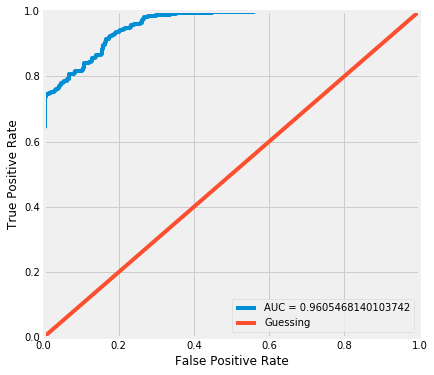

In [10]:
%%time
# Train Forest
forest.fit(x_train, y_train)

print('#### Forest (Training) ####')
print(evaluate(forest, x_train, y_train))

graph.figure(figsize=(6, 6))
plot_roc_curve(forest.predict_proba(x_train)[:, 1], y_train)
print(forest.named_steps['gridsearchcv'].best_params_)

In [11]:
# Create Neural Network
def nnet():
    # Currently creates 78 features (checked using `forest.named_steps['gridsearchcv'].best_estimator_.n_features_`)
    # Must use a sequential model for Neural Networks to work in SKLearn
    model = Sequential()
    model.add(Dense(35, input_dim=78, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(35, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(35, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
sk_net_model = KerasClassifier(
    nnet, 
    validation_split=0.2, epochs=int(1e6), batch_size=500, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=15)], verbose=2
)
sk_net = make_pipeline(preprocessor, sk_net_model)

Train on 1017 samples, validate on 255 samples
Epoch 1/1000000
 - 0s - loss: 0.5658 - acc: 0.7119 - val_loss: 0.4760 - val_acc: 0.8078
Epoch 2/1000000
 - 0s - loss: 0.5219 - acc: 0.7670 - val_loss: 0.4531 - val_acc: 0.8000
Epoch 3/1000000
 - 0s - loss: 0.5205 - acc: 0.7650 - val_loss: 0.4475 - val_acc: 0.8000
Epoch 4/1000000
 - 0s - loss: 0.5125 - acc: 0.7620 - val_loss: 0.4443 - val_acc: 0.7922
Epoch 5/1000000
 - 0s - loss: 0.5026 - acc: 0.7689 - val_loss: 0.4393 - val_acc: 0.7961
Epoch 6/1000000
 - 0s - loss: 0.4987 - acc: 0.7709 - val_loss: 0.4340 - val_acc: 0.8000
Epoch 7/1000000
 - 0s - loss: 0.4841 - acc: 0.7778 - val_loss: 0.4297 - val_acc: 0.8118
Epoch 8/1000000
 - 0s - loss: 0.4808 - acc: 0.7827 - val_loss: 0.4276 - val_acc: 0.8118
Epoch 9/1000000
 - 0s - loss: 0.4727 - acc: 0.7847 - val_loss: 0.4283 - val_acc: 0.8078
Epoch 10/1000000
 - 0s - loss: 0.4742 - acc: 0.7729 - val_loss: 0.4282 - val_acc: 0.8000
Epoch 11/1000000
 - 0s - loss: 0.4602 - acc: 0.7797 - val_loss: 0.4296 -

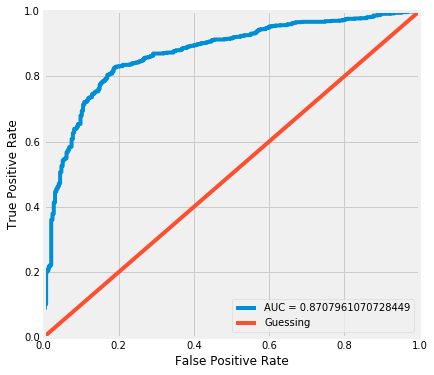

In [12]:
%%time
# Train Neural Network
sk_net.fit(x_train, y_train)

print('#### Neural Network ####')
print(evaluate(sk_net, x_train, y_train))

graph.figure(figsize=(6, 6))
plot_roc_curve(sk_net.predict_proba(x_train)[:, 1], y_train)

#### Ensemble #####
F1       = 0.9050632911392406
ROC AUC  = 0.7982565111110425
Matthews = 0.6328586894481488
Accuracy = 0.8584905660377359
None


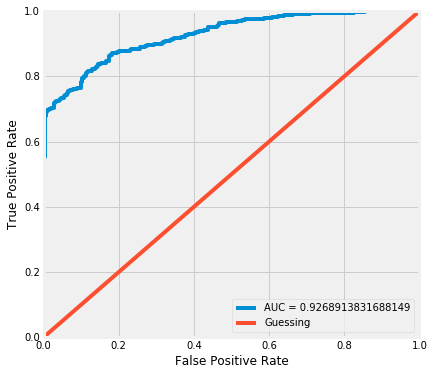

CPU times: user 472 ms, sys: 280 ms, total: 752 ms
Wall time: 424 ms


In [13]:
%%time
# Train Soft Probability Model
soft_vote = PreTrainedVoteEnsemble(trained_estimators=[('nn', sk_net), ('rf', forest)])

print('#### Ensemble #####')
print(evaluate(soft_vote, x_train, y_train))

graph.figure(figsize=(6, 6))
plot_roc_curve(soft_vote.predict_proba(x_train)[:, 1], y_train)
graph.show()

#### Forest (Testing) ####
F1       = 0.8858131487889274
ROC AUC  = 0.7740740740740741
Matthews = 0.6100736078313957
Accuracy = 0.835
None

{'max_depth': 20, 'max_features': 15, 'min_samples_split': 25, 'n_estimators': 400}


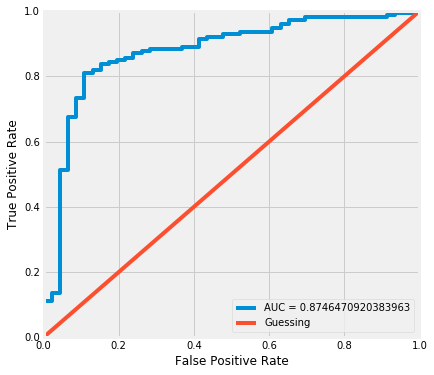

#### Neural Network (Testing) ####
F1       = 0.8860759493670887
ROC AUC  = 0.7478882391163093
Matthews = 0.46216382345751306
Accuracy = 0.82
None


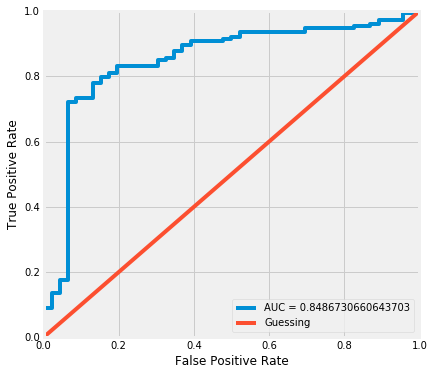

#### Ensemble (Testing) ####
F1       = 0.898360655737705
ROC AUC  = 0.7801729963508582
Matthews = 0.572668780490686
Accuracy = 0.845
None


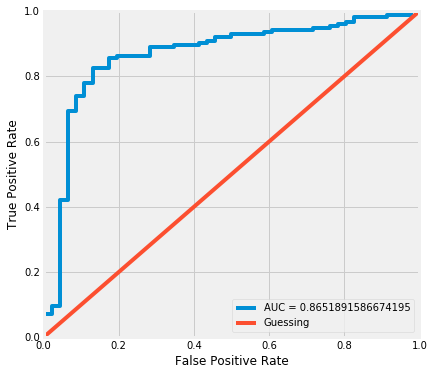

In [14]:
# Forest
print('#### Forest (Testing) ####')
print(evaluate(forest, x_test, y_test))
print()
print(forest.named_steps['gridsearchcv'].best_params_)

graph.figure(figsize=(6, 6))
plot_roc_curve(forest.predict_proba(x_test)[:, 1], y_test)
graph.show()

# ANN
print('#### Neural Network (Testing) ####')
print(evaluate(sk_net, x_test, y_test))

graph.figure(figsize=(6, 6))
plot_roc_curve(sk_net.predict_proba(x_test)[:, 1], y_test)
graph.show()

# Ensemble
print('#### Ensemble (Testing) ####')
print(evaluate(soft_vote, x_test, y_test))

graph.figure(figsize=(6, 6))
plot_roc_curve(soft_vote.predict_proba(x_test)[:, 1], y_test)
graph.show()

# NOW! Asking it Questions

Obviously what we've all been waiting for

In [15]:
# TEMP input key
for text_col in split_for(feature_names, False):
    display(Markdown(f"<b>{text_col.replace('_', ' ').title()}</b>"))
    print(list(zip(df[text_col].unique(), label_encoders[text_col].transform(df[text_col].unique()))))
    print()

<b>Education</b>

[("bachelor's degree or higher", 0), ('some college', 3), ('less than high school', 2), ('high school', 1)]



<b>Marital Status</b>

[('living with partner', 1), ('never married', 3), ('separated', 4), ('married', 2), ('divorced', 0), ('widowed', 5)]



<b>Partner Education</b>

[('some college', 3), ("bachelor's degree or higher", 0), ('high school', 1), ('less than high school', 2)]



<b>Gender</b>

[('female', 0), ('male', 1)]



<b>House</b>

[('a building with 2 or more apartments', 0), ('a one-family house detached from any other house', 3), ('a one-family house attached to one or more houses', 2), ('a mobile home', 1)]



<b>Income</b>

[('$20,000 to $24,999', 7), ('$40,000 to $49,999', 11), ('$125,000 to $149,999', 3), ('$15,000 to $19,999', 4), ('$175,000 or more', 6), ('$75,000 to $84,999', 16), ('less than $5,000', 18), ('$100,000 to $124,999', 1), ('$60,000 to $74,999', 14), ('$85,000 to $99,999', 17), ('$25,000 to $29,999', 8), ('$50,000 to $59,999', 13), ('$35,000 to $39,999', 10), ('$7,500 to $9,999', 15), ('$150,000 to $174,999', 5), ('$12,500 to $14,999', 2), ('$30,000 to $34,999', 9), ('$5,000 to $7,499', 12), ('$10,000 to $12,499', 0)]



<b>Msa</b>

[('metro', 0), ('non-metro', 1)]



<b>Rent</b>

[('rented for cash', 2), ('owned or being bought by you or someone in your household', 1), ('occupied without payment of cash rent', 0)]



<b>Political</b>

[('democrat', 0), ('republican', 2), ('other', 1)]



<b>Religion</b>

[('catholic', 2), ('jewish', 5), ('other non-christian, please specify:', 10), ('protestant (e.g., methodist, lutheran, presbyterian, episcopal)', 12), ('other christian', 9), ('none', 8), ('pentecostal', 11), ('baptist-any denomination', 0), ('eastern orthodox', 3), ('mormon', 6), ('muslim', 7), ('hindu', 4), ('buddhist', 1)]



<b>Work</b>

[('working - as a paid employee', 5), ('working - self-employed', 6), ('not working - looking for work', 1), ('not working - retired', 4), ('not working - disabled', 0), ('not working - other', 3), ('not working - on temporary layoff from a job', 2)]



<b>Gender Older</b>

[(1, 1), (0, 0)]



<b>Education Difference</b>

[(1, 1), (0, 0), (2, 2), (3, 3)]



In [16]:
print(feature_names, len(feature_names))
def ask(
    age, partner_age, age_diff_abs, n_children, visits_relatives, education, marital_status, 
    partner_education, gender, house, income, msa, rent, political, religion, work, gender_older, education_difference):
    # Initlise
    vector = [age, partner_age, age_diff_abs, n_children, visits_relatives, education, marital_status, 
        partner_education, gender, house, income, msa, rent, political, religion, work, gender_older, education_difference]
    
    vector = np.array(vector).reshape(1, len(vector))
    junk = np.vstack([vector, vector, vector])
    
    # Explanation
    explainer = LimeTabularExplainer(
        x_train, 
        class_names=['Broken Up', 'Stayed Together'], 
        feature_names=list(feature_names), 
        categorical_features=split_for(feature_indices, False), 
        categorical_names=split_for(feature_names, False), 
        discretize_continuous=True
    )
    for m, n in zip([forest, sk_net, soft_vote], ['Forest', 'Neural Network', 'Ensemble']):
        explanation = explainer.explain_instance(junk[0, :], m.predict_proba, num_features=15)
        font = '#' if n == 'Ensemble' else '###' 
        display(Markdown(f'{font} {n} Probability of Relationship Success = {explanation.predict_proba[1] * 100:0.1f}%'))
        explanation.as_pyplot_figure()
        graph.show()

['age', 'partner_age', 'age_diff_abs', 'children', 'visits_relatives', 'education', 'marital_status', 'partner_education', 'gender', 'house', 'income', 'msa', 'rent', 'political', 'religion', 'work', 'gender_older', 'education_difference'] 18


### Forest Probability of Relationship Success = 72.3%

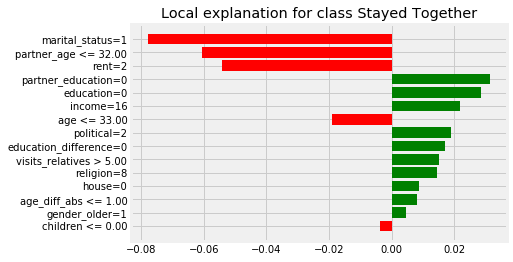

### Neural Network Probability of Relationship Success = 94.8%

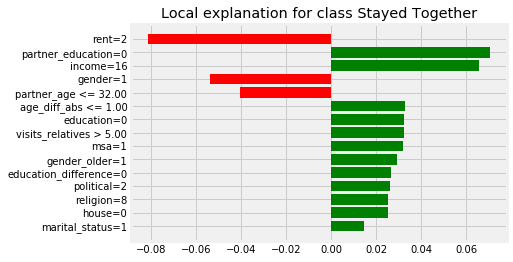

# Ensemble Probability of Relationship Success = 83.5%

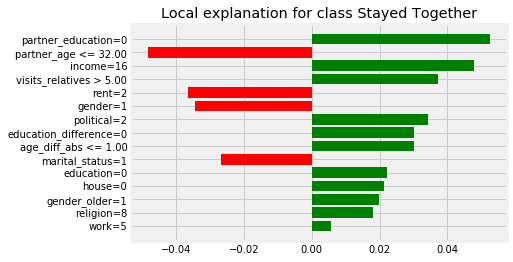

In [17]:
ask(25, 26, 1, 0, 8, 0, 1, 0, 1, 0, 16, 1, 2, 2, 8, 5, 1, 0)

_Stephen Anthony Rose_